# Práctica de Sistemas Recomendadores: pyreclab - Funk's SVD

En este práctico implementaremos un recomendador basado en un algoritmo de factorización matricial propuesto por [Simon Funk](https://sifter.org/simon/journal/20061211.html).

Volveremos a utilizar la biblioteca de Python [pyreclab](https://github.com/gasevi/pyreclab), desarrollado por los Laboratorios IALab y SocVis de la Pontificia Universidad Católica de Chile.

**Adaptado por**: Vladimir Araujo

**Material original de**: Denis Parra, Gabriel Sepúlveda, Antonio Ossa, Manuel Cartagena


## Configuración inicial

**Paso 1:** Descargue directamente a Colab los archivos del dataset ejecutando las siguientes 3 celdas:

In [1]:
!curl -L -o "u2.base" "https://drive.google.com/uc?export=download&id=1bGweNw7NbOHoJz11v6ld7ymLR8MLvBsA"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0    338      0 --:--:--  0:00:01 --:--:--   338
100 1546k  100 1546k    0     0   802k      0  0:00:01  0:00:01 --:--:--  167M


In [2]:
!curl -L -o "u2.test" "https://drive.google.com/uc?export=download&id=1f_HwJWC_1HFzgAjKAWKwkuxgjkhkXrVg"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0    540      0 --:--:-- --:--:-- --:--:--   539
100  385k  100  385k    0     0   157k      0  0:00:02  0:00:02 --:--:--  729k


In [3]:
!curl -L -o "u.item" "https://drive.google.com/uc?export=download&id=10YLhxkO2-M_flQtyo9OYV4nT9IvSESuz"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0    586      0 --:--:-- --:--:-- --:--:--   585
100  230k  100  230k    0     0   190k      0  0:00:01  0:00:01 --:--:--  225M


**Paso 2**: Instalamos [`pyreclab`](https://github.com/gasevi/pyreclab) y [`seaborn`](https://seaborn.pydata.org/index.html) utilizando `pip`.

In [4]:
!pip install pyreclab --upgrade
#!pip install seaborn --upgrade

     |████████████████████████████████| 235kB 5.3MB/s 


In [5]:
import pandas as pd
import pyreclab
import seaborn as sns
import numpy as np
import scipy.sparse as sparse
import matplotlib.pyplot as plt

%matplotlib inline
sns.set(style="whitegrid")

## Antes de recomendar

**Paso 3**: Los archivos `u2.base` y `u2.test` tienen tuplas (usuario, item, rating, timestamp), que es la información de preferencias de usuarios sobre películas en una muestra del dataset [MovieLens](https://grouplens.org/datasets/movielens/). Revisemos cómo es uno de estos archivos y luego haremos gráficos que nos permitan sacar conclusiones a partir del mismo.

In [8]:
# Primero creamos el dataframe con los datos
df_train = pd.read_csv('u2.base',
                         sep='\t',
                         names=['userid', 'itemid', 'rating', 'timestamp'],
                         header=None)
df_train.head()

,userid,itemid,rating,timestamp
0,1,3,4,878542960
1,1,4,3,876893119
2,1,5,3,889751712
3,1,6,5,887431973
4,1,7,4,875071561


In [9]:
# Ahora queremos realizar una observación rápida de los datos
df_train.describe()

,userid,itemid,rating,timestamp
count,80000.000000,80000.000000,80000.000000,8.000000e+04
mean,494.508137,424.990487,3.526463,8.835467e+08
std,276.879511,330.564093,1.124429,5.379549e+06
min,1.000000,1.000000,1.000000,8.747247e+08
25%,269.000000,174.000000,3.000000,8.794471e+08
50%,500.000000,321.000000,4.000000,8.828278e+08
75%,744.000000,630.000000,4.000000,8.884652e+08
max,943.000000,1682.000000,5.000000,8.932866e+08


Por otra parte, para obtener información adicional de cada película tal como **título**, **fecha de lanzamiento**, **género**, etc., cargaremos el archivo de items descargado (`u.item`) para poder mapear cada identificador de ítem al conjunto de datos que lo describe. Revisemos el contenido de este archivo

In [10]:
columns = ['movieid', 'title', 'release_date', 'video_release_date', \
           'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', \
           'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', \
           'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', \
           'Thriller', 'War', 'Western']

In [11]:
# Cargamos el dataset con los items
df_items = pd.read_csv('u.item',
                        sep='|',
                        index_col=0,
                        names = columns,
                        header=None, 
                        encoding='latin-1')
df_items.head()

,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieid,,,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [12]:
# Realizamos una inspección sobre estos datos (.info())
df_items.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1682 entries, 1 to 1682
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   title               1682 non-null   object 
 1   release_date        1681 non-null   object 
 2   video_release_date  0 non-null      float64
 3   IMDb_URL            1679 non-null   object 
 4   unknown             1682 non-null   int64  
 5   Action              1682 non-null   int64  
 6   Adventure           1682 non-null   int64  
 7   Animation           1682 non-null   int64  
 8   Children            1682 non-null   int64  
 9   Comedy              1682 non-null   int64  
 10  Crime               1682 non-null   int64  
 11  Documentary         1682 non-null   int64  
 12  Drama               1682 non-null   int64  
 13  Fantasy             1682 non-null   int64  
 14  Film-Noir           1682 non-null   int64  
 15  Horror              1682 non-null   int64  
 16  Musica

In [13]:
# Ejemplo de cómo visualizar titulos de peliculas en base a sus IDs
pelis = [5,4,1]
df_items.loc[pelis]['title']

movieid
5       Copycat (1995)
4    Get Shorty (1995)
1     Toy Story (1995)
Name: title, dtype: object

**Paso 4:** Generemos algunos gráficos en relación a las películas.

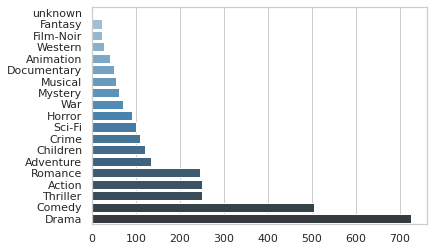

In [14]:
#Ignorar el warning
genre_columns = ['unknown', 'Action', 'Adventure', 'Animation', \
           'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', \
           'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', \
           'Thriller', 'War', 'Western']

genre_count = df_items[genre_columns].sum().sort_values()

sns.barplot(x=genre_count.values, y=genre_count.index, label="Total", palette="Blues_d")

Antes de trabajar con SVD, responda las siguientes preguntas.

**Pregunta:** Explique cómo funciona SVD (como modelo, no piense en la implementación), y cómo funciona el método `train()` en  `pyreclab`





**Respuesta:** SVD logra realizar la predicción de ratings mediante la factorización de la matriz user-item en matriz usuario y matriz de items. Cada una de estas dos matrices tiene el número de columnas igual a la cantidad de factores latentes que el modelo debe aprender. Las filas se asocian al usuario o item respectivo. El producto de estas matrices se basa en los productos puntos entre fila usuario y fila item teniendo como entradas los factores latentes. Estos factores latentes se asocian a características del usuario e item respectivamente. En el producto punto, las características similares dan un mayor rating (positivas o negativas) y las características distintas un menor rating de resultado. De alguna manera estos factores latentes logran representar la afinidad entre usuario e items. Estos factores latentes se aprenden mediante métodos de descenso de gradiente. La cantidad de valores a estimar respecto la matriz original es mucho menor.


El método train precisamente se encarga de realizar el descenso de gradiente y actualizar los valores de los factores latentes de la matrices usuario e item.

## SVD

**Paso 5**: Tome un usuario, cualquiera, del dataset y reporte parte de sus gustos explícitamente (es decir, nombre de las películas, género, etc., no id). Para este mismo usuario, revise explícitamente las recomendaciones al llegar a la parametrización que reporta las mejores métricas.

In [16]:
user_id = 88
user_df = df_train[df_train['userid'] == user_id]

df_items.loc[user_df['itemid'].values]

,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieid,,,,,,,,,,,,,,,,,,,,,,,
261,Air Bud (1997),01-Aug-1997,NaN,http://us.imdb.com/M/title-exact?Air+Bud+(1997),0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
286,"English Patient, The (1996)",15-Nov-1996,NaN,http://us.imdb.com/M/title-exact?English%20Pat...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0
301,In & Out (1997),19-Sep-1997,NaN,http://us.imdb.com/Title?In+%26+Out+(1997),0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
302,L.A. Confidential (1997),01-Jan-1997,NaN,http://us.imdb.com/M/title-exact?L%2EA%2E+Conf...,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0
315,Apt Pupil (1998),23-Oct-1998,NaN,http://us.imdb.com/Title?Apt+Pupil+(1998),0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
321,Mother (1996),25-Dec-1996,NaN,http://us.imdb.com/M/title-exact?Mother%20(199...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
326,G.I. Jane (1997),01-Jan-1997,NaN,http://us.imdb.com/M/title-exact?G%2EI%2E+Jane...,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
354,"Wedding Singer, The (1998)",13-Feb-1998,NaN,http://us.imdb.com/M/title-exact?Wedding+Singe...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
690,Seven Years in Tibet (1997),01-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Seven+Years+i...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0


Al usuario le gustan las comedias y dramas de los 90s. No prefiere aventuras documentales, horror, western, y musicales

---



In [22]:
# Definicion de objeto svd
svd = pyreclab.SVD(dataset='u2.base',
                   dlmchar=b'\t',
                   header=False,
                   usercol=0,
                   itemcol=1,
                   ratingcol=2)

# Entrenamiento del modelo
svd.train(factors=100, maxiter=100, lr=0.01, lamb=0.1)

In [23]:
# Testing de predicciones
predlist, mae, rmse = svd.test(input_file='u2.test',
                               dlmchar=b'\t',
                               header=False,
                               usercol=0,
                               itemcol=1,
                               ratingcol=2)

print('MAE: {}\nRMSE: {}'.format(mae, rmse))

MAE: 0.7206190770306239
RMSE: 0.9143895414702325


In [24]:
# Testing de recomendaciones
top_n = 20

recommendList, maprec, ndcg = svd.testrec(input_file='u2.test',
                                          dlmchar=b'\t',
                                          header=False,
                                          usercol=0,
                                          itemcol=1,
                                          ratingcol=2,
                                          topn=top_n,
                                          relevance_threshold=2,
                                          includeRated=False)

print('MAP: {}\nNDCG@{}: {}'.format(maprec, top_n, ndcg))

MAP: 0.10749217947593788
NDCG@20: 0.06066916934865034


In [25]:
# Calcular las recomendaciones para el usuario escogido
print('MAP: {}\nNDCG@{}: {}'.format(maprec, top_n, ndcg))
ranking = [int(r) for r in svd.recommend(str(user_id), top_n, includeRated=False)]
print('Recommendation for user {}: {}'.format(user_id, ranking))
df_items.loc[ranking]

Recommendation for user 88: [143, 1449, 1159, 694, 64, 1251, 1467, 169, 489, 1064, 114, 1233, 900, 1653, 1642, 22, 485, 71, 116, 1269]


In [26]:
# Ver explicitamente las recomendaciones para un usuario
df_items.loc[ranking]

,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieid,,,,,,,,,,,,,,,,,,,,,,,
143,"Sound of Music, The (1965)",01-Jan-1965,NaN,http://us.imdb.com/M/title-exact?Sound%20of%20...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1449,Pather Panchali (1955),22-Mar-1996,NaN,http://us.imdb.com/M/title-exact?Pather%20Panc...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1159,Stalker (1979),01-Jan-1979,NaN,http://us.imdb.com/M/title-exact?Stalker%20(1979),0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0
694,Persuasion (1995),25-Sep-1995,NaN,http://us.imdb.com/Title?Persuasion+(1995/I),0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
64,"Shawshank Redemption, The (1994)",01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?Shawshank%20R...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1251,A Chef in Love (1996),25-Apr-1997,NaN,http://us.imdb.com/M/title-exact?Mille%20et%20...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1467,"Saint of Fort Washington, The (1993)",01-Jan-1993,NaN,http://us.imdb.com/M/title-exact?Saint%20of%20...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
169,"Wrong Trousers, The (1993)",01-Jan-1993,NaN,http://us.imdb.com/M/title-exact?Wrong%20Trous...,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
489,Notorious (1946),01-Jan-1946,NaN,http://us.imdb.com/M/title-exact?Notorious%20(...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0


Las recomendaciones respetan las no preferencias del usuario a excepción de la recomendación de un musical dentro de las 20 selecciones. Logra recomendar comedia, drama y peliculas de los 90s.

**Paso 6:** Pruebe distintos valores de los parámetros de entrenamiento del algoritmo SVD:
- Número de factores
- Número de iteraciones máxima
- Learning rate
- Lambda

Describa cómo estos afectan las métricas y las recomendaciones hechas para el usuario que escogió:

Se prueba duplicar el número de factores latentes. Se observa una reducción del MAE y RMSE y aumento de MAP y nDCG@20. Esto indica una mejoría del rendimiento.

In [30]:
# Definicion de objeto svd
svd = pyreclab.SVD(dataset='u2.base',
                   dlmchar=b'\t',
                   header=False,
                   usercol=0,
                   itemcol=1,
                   ratingcol=2)

# Entrenamiento del modelo
svd.train(factors=200, maxiter=100, lr=0.01, lamb=0.1)

# Testing de predicciones
predlist, mae, rmse = svd.test(input_file='u2.test',
                               dlmchar=b'\t',
                               header=False,
                               usercol=0,
                               itemcol=1,
                               ratingcol=2)

print('MAE: {}\nRMSE: {}'.format(mae, rmse))

# Testing de recomendaciones
top_n = 20

recommendList, maprec, ndcg = svd.testrec(input_file='u2.test',
                                          dlmchar=b'\t',
                                          header=False,
                                          usercol=0,
                                          itemcol=1,
                                          ratingcol=2,
                                          topn=top_n,
                                          relevance_threshold=2,
                                          includeRated=False)

print('MAP: {}\nNDCG@{}: {}'.format(maprec, top_n, ndcg))

MAE: 0.7205969478709363
RMSE: 0.9139756404858339
MAP: 0.11816537898923495
NDCG@20: 0.06687176029148018


Dada la mejora del modelo al configurar 200 factores latentes, se mantiene y se duplica el hiperparámetro max iter para observar el efecto en el rendimiento.

Se observa un aumento de las métricas de error y disminuición de Mean Average Precision junto a nDCG. Esto indica que el aumento de iteraciones empeoró el rendimiento probablemente dado por overfitting.



In [31]:
# Definicion de objeto svd
svd = pyreclab.SVD(dataset='u2.base',
                   dlmchar=b'\t',
                   header=False,
                   usercol=0,
                   itemcol=1,
                   ratingcol=2)

# Entrenamiento del modelo
svd.train(factors=200, maxiter=200, lr=0.01, lamb=0.1)

# Testing de predicciones
predlist, mae, rmse = svd.test(input_file='u2.test',
                               dlmchar=b'\t',
                               header=False,
                               usercol=0,
                               itemcol=1,
                               ratingcol=2)

print('MAE: {}\nRMSE: {}'.format(mae, rmse))

# Testing de recomendaciones
top_n = 20

recommendList, maprec, ndcg = svd.testrec(input_file='u2.test',
                                          dlmchar=b'\t',
                                          header=False,
                                          usercol=0,
                                          itemcol=1,
                                          ratingcol=2,
                                          topn=top_n,
                                          relevance_threshold=2,
                                          includeRated=False)

print('MAP: {}\nNDCG@{}: {}'.format(maprec, top_n, ndcg))

MAE: 0.721041509808774
RMSE: 0.914867953450038
MAP: 0.11724002551281165
NDCG@20: 0.06268548483024776


Se prueba setear el learning rate a 0.1. Empeoran todas las métricas a excepción del MAP.

In [32]:
# Definicion de objeto svd
svd = pyreclab.SVD(dataset='u2.base',
                   dlmchar=b'\t',
                   header=False,
                   usercol=0,
                   itemcol=1,
                   ratingcol=2)

# Entrenamiento del modelo
svd.train(factors=200, maxiter=100, lr=0.1, lamb=0.1)

# Testing de predicciones
predlist, mae, rmse = svd.test(input_file='u2.test',
                               dlmchar=b'\t',
                               header=False,
                               usercol=0,
                               itemcol=1,
                               ratingcol=2)

print('MAE: {}\nRMSE: {}'.format(mae, rmse))

# Testing de recomendaciones
top_n = 20

recommendList, maprec, ndcg = svd.testrec(input_file='u2.test',
                                          dlmchar=b'\t',
                                          header=False,
                                          usercol=0,
                                          itemcol=1,
                                          ratingcol=2,
                                          topn=top_n,
                                          relevance_threshold=2,
                                          includeRated=False)

print('MAP: {}\nNDCG@{}: {}'.format(maprec, top_n, ndcg))

MAE: 0.7644819683556304
RMSE: 0.96178533500787
MAP: 0.1278658038242529
NDCG@20: 0.06105417091229263


Se setea factor de regularización lambda a 0.01. Mejoran las métricas de selección MAP y nDCG pero empeoran las de predicción de rating MAE y RMSE

In [33]:
# Definicion de objeto svd
svd = pyreclab.SVD(dataset='u2.base',
                   dlmchar=b'\t',
                   header=False,
                   usercol=0,
                   itemcol=1,
                   ratingcol=2)

# Entrenamiento del modelo
svd.train(factors=200, maxiter=100, lr=0.01, lamb=0.01)

# Testing de predicciones
predlist, mae, rmse = svd.test(input_file='u2.test',
                               dlmchar=b'\t',
                               header=False,
                               usercol=0,
                               itemcol=1,
                               ratingcol=2)

print('MAE: {}\nRMSE: {}'.format(mae, rmse))

# Testing de recomendaciones
top_n = 20

recommendList, maprec, ndcg = svd.testrec(input_file='u2.test',
                                          dlmchar=b'\t',
                                          header=False,
                                          usercol=0,
                                          itemcol=1,
                                          ratingcol=2,
                                          topn=top_n,
                                          relevance_threshold=2,
                                          includeRated=False)

print('MAP: {}\nNDCG@{}: {}'.format(maprec, top_n, ndcg))

MAE: 0.7600524132927323
RMSE: 0.9674359905337104
MAP: 0.16440363872589414
NDCG@20: 0.09227921868496518


**Paso 7:** Genere un gráfico explorando todos los parámetros que ofrece el modelo `SVD`, donde se grafiquen los valores probados para cada parámetro y el RMSE obtenido para cada uno. Debe probar una cantidad razonable de valores buscando la mejor parametrización y entregar el notebook con dicha parametrización.



In [46]:
# Ejemplo
factor_values = [200, 250, 300, 350, 400, 450, 500] # definir distintos numeros de factores
mae_values = [] # para almacenar resultados de MAE
rmse_values = [] # para almacenar valores de RMSE
map_values = []
ndcg_values = []

for f in factor_values:
  svd.train(factors=f, maxiter=100, lr=0.01, lamb=0.1)
  
  predlist, mae, rmse = svd.test(input_file='u2.test',
                                 dlmchar=b'\t',
                                 header=False,
                                 usercol=0,
                                 itemcol=1,
                                 ratingcol=2)
  
  recommendList, maprec, ndcg = svd.testrec(input_file='u2.test',
                                          dlmchar=b'\t',
                                          header=False,
                                          usercol=0,
                                          itemcol=1,
                                          ratingcol=2,
                                          topn=top_n,
                                          relevance_threshold=2,
                                          includeRated=False)
  
  mae_values.append(mae)
  rmse_values.append(rmse)
  map_values.append(maprec)
  ndcg_values.append(ndcg)

print(mae_values)
print(rmse_values)
print(map_values)
print(ndcg_values)

[0.7205400664489079, 0.7200248778439393, 0.7201673359748105, 0.7202449877236728, 0.7200606500921296, 0.7200585282806966, 0.7197215134160857]
[0.913607838136186, 0.9134451321227997, 0.9133421453631188, 0.9135731741687577, 0.9133629552603972, 0.9128195142510848, 0.9125168789220522]
[0.12382745588410558, 0.1309162813564894, 0.1292814957159429, 0.13992080724033315, 0.14284227466153984, 0.14626565044365744, 0.14790652509311655]
[0.06806436099863376, 0.07524880456018528, 0.07471688334203694, 0.0786439910511774, 0.08157999933685102, 0.08358831950573653, 0.08363664962654956]


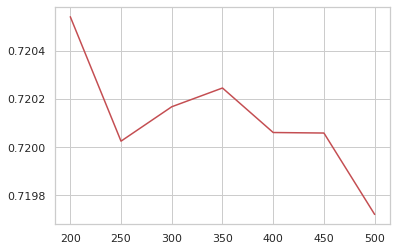

In [47]:
plt.plot(factor_values, mae_values, 'r-')
plt.show()

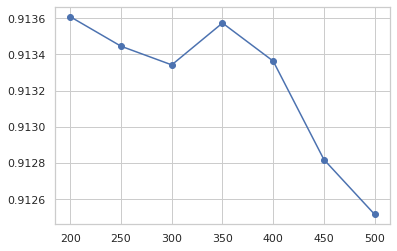

In [48]:
plt.plot(factor_values, rmse_values, 'bo-')
plt.show()

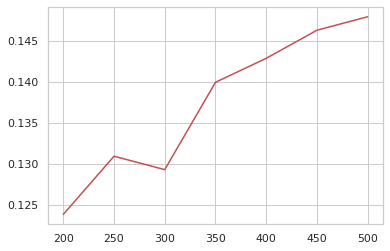

In [49]:
plt.plot(factor_values, map_values, 'r-')
plt.show()

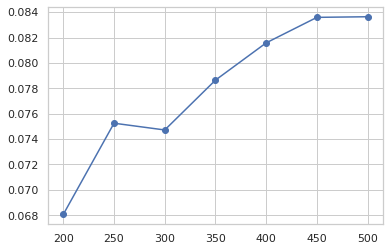

In [50]:
plt.plot(factor_values, ndcg_values, 'bo-')
plt.show()

**Paso 8:** Pruebe con otros valores y/o parámetros:

In [57]:
# Ejemplo
maxiter_values = [25, 50, 75, 100, 125, 150] # definir distintos numeros de factores
mae_values = [] # para almacenar resultados de MAE
rmse_values = [] # para almacenar valores de RMSE
map_values = []
ndcg_values = []

for m in maxiter_values:
  svd.train(factors=500, maxiter=m, lr=0.01, lamb=0.1)
  
  predlist, mae, rmse = svd.test(input_file='u2.test',
                                 dlmchar=b'\t',
                                 header=False,
                                 usercol=0,
                                 itemcol=1,
                                 ratingcol=2)
  
  recommendList, maprec, ndcg = svd.testrec(input_file='u2.test',
                                          dlmchar=b'\t',
                                          header=False,
                                          usercol=0,
                                          itemcol=1,
                                          ratingcol=2,
                                          topn=top_n,
                                          relevance_threshold=2,
                                          includeRated=False)
  
  mae_values.append(mae)
  rmse_values.append(rmse)
  map_values.append(maprec)
  ndcg_values.append(ndcg)

print(mae_values)
print(rmse_values)
print(map_values)
print(ndcg_values)

[0.7245978477441346, 0.7210339408948574, 0.719876898905935, 0.7201432219745644, 0.720551762961152, 0.7207458143254674]
[0.9184501546098489, 0.9142653061035304, 0.9133235133094624, 0.9129953721736774, 0.9136150887071092, 0.9139632091008728]
[0.16408378321048434, 0.1514170056778003, 0.15489232199258435, 0.14162539453805267, 0.14242684889365342, 0.14422890578842934]
[0.1002778563429637, 0.09248043251386956, 0.08909295488802738, 0.08307710199871621, 0.08073305483927304, 0.07877007974152855]


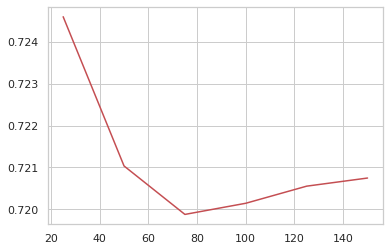

In [58]:
plt.plot(maxiter_values, mae_values, 'r-')
plt.show()

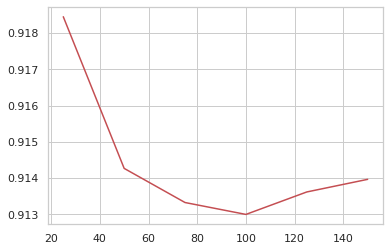

In [59]:
plt.plot(maxiter_values, rmse_values, 'r-')
plt.show()

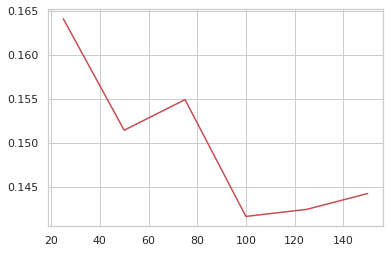

In [60]:
plt.plot(maxiter_values, map_values, 'r-')
plt.show()

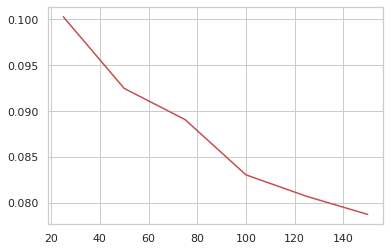

In [61]:
plt.plot(maxiter_values, ndcg_values, 'r-')
plt.show()

In [62]:
# Ejemplo
learning_rate = [0.1, 0.01, 0.001] # definir distintos numeros de factores
mae_values = [] # para almacenar resultados de MAE
rmse_values = [] # para almacenar valores de RMSE
map_values = []
ndcg_values = []

for l in learning_rate:
  svd.train(factors=500, maxiter=80, lr=l, lamb=0.1)
  
  predlist, mae, rmse = svd.test(input_file='u2.test',
                                 dlmchar=b'\t',
                                 header=False,
                                 usercol=0,
                                 itemcol=1,
                                 ratingcol=2)
  
  recommendList, maprec, ndcg = svd.testrec(input_file='u2.test',
                                          dlmchar=b'\t',
                                          header=False,
                                          usercol=0,
                                          itemcol=1,
                                          ratingcol=2,
                                          topn=top_n,
                                          relevance_threshold=2,
                                          includeRated=False)
  
  mae_values.append(mae)
  rmse_values.append(rmse)
  map_values.append(maprec)
  ndcg_values.append(ndcg)

print(mae_values)
print(rmse_values)
print(map_values)
print(ndcg_values)

[0.7642472466035175, 0.7196948250630745, 0.7468937433149866]
[0.9614826316103595, 0.912210752677146, 0.9433416084325774]
[0.13188605572179923, 0.15024275230005377, 0.16127349702494526]
[0.06147556905093656, 0.08826772831019285, 0.1001601462266742]


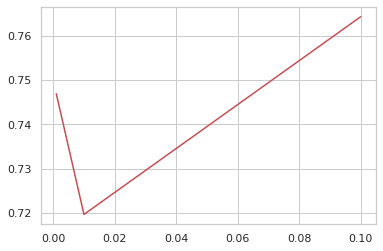

In [63]:
plt.plot(learning_rate, mae_values, 'r-')
plt.show()

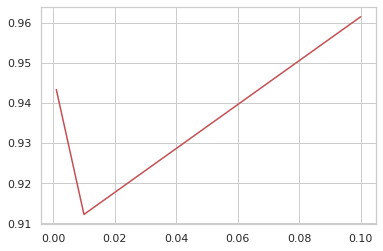

In [64]:
plt.plot(learning_rate, rmse_values, 'r-')
plt.show()

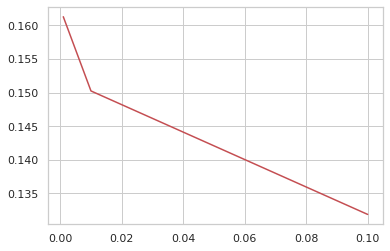

In [65]:
plt.plot(learning_rate, map_values, 'r-')
plt.show()

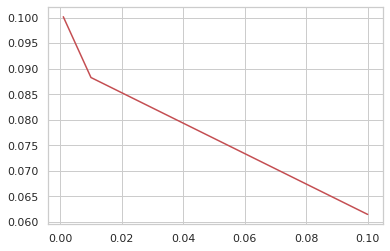

In [66]:
plt.plot(learning_rate, ndcg_values, 'r-')
plt.show()

In [67]:
# Ejemplo
lambda_values = [0.1, 0.01, 0.001] # definir distintos numeros de factores
mae_values = [] # para almacenar resultados de MAE
rmse_values = [] # para almacenar valores de RMSE
map_values = []
ndcg_values = []

for l in lambda_values:
  svd.train(factors=500, maxiter=80, lr=0.01, lamb=l)
  
  predlist, mae, rmse = svd.test(input_file='u2.test',
                                 dlmchar=b'\t',
                                 header=False,
                                 usercol=0,
                                 itemcol=1,
                                 ratingcol=2)
  
  recommendList, maprec, ndcg = svd.testrec(input_file='u2.test',
                                          dlmchar=b'\t',
                                          header=False,
                                          usercol=0,
                                          itemcol=1,
                                          ratingcol=2,
                                          topn=top_n,
                                          relevance_threshold=2,
                                          includeRated=False)
  
  mae_values.append(mae)
  rmse_values.append(rmse)
  map_values.append(maprec)
  ndcg_values.append(ndcg)

print(mae_values)
print(rmse_values)
print(map_values)
print(ndcg_values)

[0.7198002870040848, 0.7471113785796245, 0.7860419439415913]
[0.9126317202651806, 0.948861122724172, 0.9971171959236129]
[0.1452579706021434, 0.1933802149472682, 0.18362441201428314]
[0.0867636042074638, 0.10630176193203843, 0.09944154018555998]


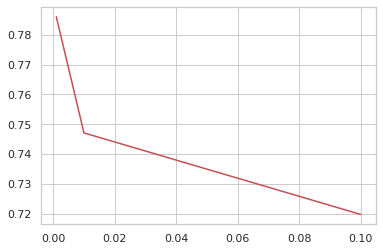

In [69]:
plt.plot(lambda_values, mae_values, 'r-')
plt.show()

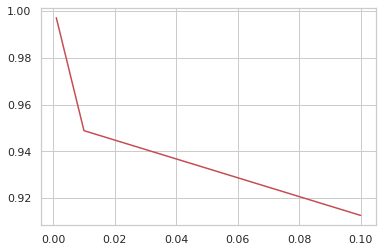

In [70]:
plt.plot(lambda_values, rmse_values, 'r-')
plt.show()

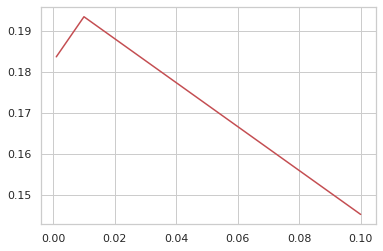

In [71]:
plt.plot(lambda_values, map_values, 'r-')
plt.show()

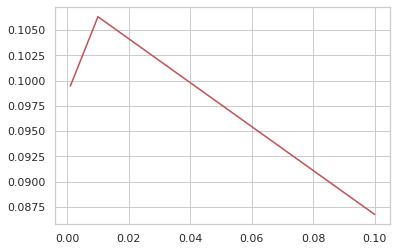

In [72]:
plt.plot(lambda_values, ndcg_values, 'r-')
plt.show()

La mejor parametrización es la siguiente

In [73]:
svd.train(factors=500, maxiter=80, lr=0.01, lamb=0.01)
  
predlist, mae, rmse = svd.test(input_file='u2.test',
                                 dlmchar=b'\t',
                                 header=False,
                                 usercol=0,
                                 itemcol=1,
                                 ratingcol=2)

recommendList, maprec, ndcg = svd.testrec(input_file='u2.test',
                                          dlmchar=b'\t',
                                          header=False,
                                          usercol=0,
                                          itemcol=1,
                                          ratingcol=2,
                                          topn=top_n,
                                          relevance_threshold=2,
                                          includeRated=False)

In [74]:
print('MAP: {}\nNDCG@{}: {}'.format(maprec, top_n, ndcg))
ranking = [int(r) for r in svd.recommend(str(user_id), top_n, includeRated=False)]
print('Recommendation for user {}: {}'.format(user_id, ranking))
df_items.loc[ranking]

MAP: 0.18681289391117528
NDCG@20: 0.10485750577354097
Recommendation for user 88: [318, 64, 520, 429, 69, 22, 496, 172, 189, 28, 83, 210, 114, 481, 317, 98, 178, 735, 133, 174]


,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieid,,,,,,,,,,,,,,,,,,,,,,,
318,Schindler's List (1993),01-Jan-1993,NaN,http://us.imdb.com/M/title-exact?Schindler's%2...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
64,"Shawshank Redemption, The (1994)",01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?Shawshank%20R...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
520,"Great Escape, The (1963)",01-Jan-1963,NaN,http://us.imdb.com/M/title-exact?Great%20Escap...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
429,"Day the Earth Stood Still, The (1951)",01-Jan-1951,NaN,http://us.imdb.com/M/title-exact?Day%20the%20E...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
69,Forrest Gump (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?Forrest%20Gum...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0
22,Braveheart (1995),16-Feb-1996,NaN,http://us.imdb.com/M/title-exact?Braveheart%20...,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
496,It's a Wonderful Life (1946),01-Jan-1946,NaN,http://us.imdb.com/M/title-exact?It's%20a%20Wo...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
172,"Empire Strikes Back, The (1980)",01-Jan-1980,NaN,http://us.imdb.com/M/title-exact?Empire%20Stri...,0,1,1,0,0,0,0,0,1,0,0,0,0,0,1,1,0,1,0
189,"Grand Day Out, A (1992)",01-Jan-1992,NaN,http://us.imdb.com/M/title-exact?Grand%20Day%2...,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


Las no preferencias del usuario no aparecen en esta nueva recomendación. Hay más comedias y dramas como tambien películas del 90.